# 1 Continuous Attractor Neural Network


Here we will implement the following paper:

- Si Wu, Kosuke Hamaguchi, and Shun-ichi Amari. “Dynamics and computation of continuous attractors.” Neural computation 20.4 (2008): 994-1025.



## 1.1 Customize a ring CANN in brainpy

在本次项目中，我们的主要目标是实现一个连续吸引子神经网络。该网络的神经动力学为：

1. Synaptic current dynamics (exponential conductance model): 

$$ 
\tau\frac{dU(x,t)}{dt} = -U(x,t) + I^{rec} (x,t) + I^{ext}(x,t)
$$

where the recurrent input $I_{rec}(x,t) = \int_{x'}J(x,x')r(x',t)dx'$, which represents a weighted sum of all recurrently connected neurons' firing rate,

2. Activation function (which transfer the synaptic current to firing rates):

$$
r(x,t) = \frac{U(x,t)^2}{1+k\int_x' U(x',t)^2dx'}
$$

3. Synaptic connection strength matrix

$$
J(x,t) = J_0 exp [-\frac{dist(x，x')^2}{2a^2}]
$$

where $dist(x, x')$ represents the distance of two features, e.g., in Euler space the $dist(x,x') = |x-x'|$.



In simulations, we can not simulate a CANN encoding features ranging $(-\inf, \inf)$. Instead, we simulate a ring attractor network which encodes features ranging $(-\pi, \pi)$. Note that the distance on a ring should be:

$$
dist_{ring}(x,x') = min(|x-x'|,2\pi-|x-x'|)
$$


![dasda](figs/s01apgi89t.png)

首先，导入BrainPy和相关的Python依赖包。

In [2]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt

我们将连续吸引子网络定义为一个``brainpy.dyn.NeuDyn``子类。那么其实现的具体流程为：

1、初始化模型的参数；

2、初始化特征空间相关参数；

3、初始化变量

4、定义积分函数

5、距离函数：将距离转换到``[-z_range/2, z_range/2)``之间

6、波包输入函数：获取各个神经元到pos处神经元的输入

7、网络更新函数

**任务1**：我们需要完成如下公式的编程，即将微分方程写成Python微分函数：
$$ 
\tau\frac{dU(x,t)}{dt} = -U(x,t) + I^{rec} (x,t) + I^{ext}(x,t)
$$



**任务2**：我们需要完成距离公式的定义，将距离按照公式转换到``[-z_range/2, z_range/2)``之间，距离公式为：

$$dist_{ring}(x,x') = min(|x-x'|,2\pi-|x-x'|)$$


In [3]:
class CANN1D(bp.dyn.NeuDyn):
  def __init__(self, num, tau=1., k=8.1, a=0.5, A=10., J0=4., z_min=-bm.pi, z_max=bm.pi, **kwargs):
    super().__init__(size=num, **kwargs)

    # 1、初始化参数
    self.tau = tau
    self.k = k
    self.a = a
    self.A = A
    self.J0 = J0

    # 2、初始化特征空间相关参数
    self.z_min = z_min
    self.z_max = z_max
    self.z_range = z_max - z_min
    self.x = bm.linspace(z_min, z_max, num)
    self.rho = num / self.z_range
    self.dx = self.z_range / num

    # 3、初始化变量
    self.u = bm.Variable(bm.zeros(num))
    self.input = bm.Variable(bm.zeros(num))
    self.conn_mat = self.make_conn(self.x)  # 连接矩阵

    # 4、定义积分函数
    self.integral = bp.odeint(self.derivative)

  # 微分方程
  def derivative(self, u, t, Irec, Iext):
    # TODO：定义微分方程？？？
    du = (-u + Irec + Iext) / self.tau #？ t是什么
    return du

  # 6、将距离转换到[-z_range/2, z_range/2)之间
  def dist(self, d):
    d = bm.remainder(d, self.z_range)
    # TODO：实现一维的环的距离度量？？？
    d = bm.where(d > 0.5 * self.z_range, d - self.z_range, d)
    return d

  # 计算连接矩阵
  def make_conn(self, x):
    assert bm.ndim(x) == 1
    d = self.dist(x - x[:, None])  # 距离矩阵
    Jxx = self.J0 * bm.exp(-0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a) 
    return Jxx

  # 6、获取各个神经元到pos处神经元的输入
  def get_stimulus_by_pos(self, pos):
    return self.A * bm.exp(-0.25 * bm.square(self.dist(self.x - pos) / self.a))

  # 7、网络更新函数
  def update(self, x=None):
    _t = bp.share['t']
    u2 = bm.square(self.u)
    r = u2 / (1.0 + self.k * bm.sum(u2))
    Irec = bm.dot(self.conn_mat, r)
    self.u[:] = self.integral(self.u, _t,Irec, self.input)
    self.input[:] = 0.  # 重置外部电流

## 1.2 Simulate the persistent activity of CANN after the removal of external input

接下来，我们首先输入一个高斯波包当作外部输入来激活CANN模型，然后，我们去除这个输入，并检查CANN模型的总体响应。

在下面的代码中，我们已经写好了输入参数：前2ms没有外界输入，接下来10 ms在位置为0的地方给高斯波包输入，在最后10ms内不给输入。

**主要任务**：将实例化后的``cann``模型输入给``brainpy.DSRunner``，并监控历史变量``u``。探究：1、在BrainPy如何监控变量``u``。2、改变参数`k`，网络对撤掉外界输入的响应如何变化。



  0%|          | 0/220 [00:00<?, ?it/s]

Saving the animation into CANN_k=0.01.gif ...
MovieWriter imagemagick unavailable; using Pillow instead.


  0%|          | 0/220 [00:00<?, ?it/s]

Saving the animation into CANN_k=0.1.gif ...
MovieWriter imagemagick unavailable; using Pillow instead.


  0%|          | 0/220 [00:00<?, ?it/s]

Saving the animation into CANN_k=0.5.gif ...
MovieWriter imagemagick unavailable; using Pillow instead.


  0%|          | 0/220 [00:00<?, ?it/s]

Saving the animation into CANN_k=1.gif ...
MovieWriter imagemagick unavailable; using Pillow instead.


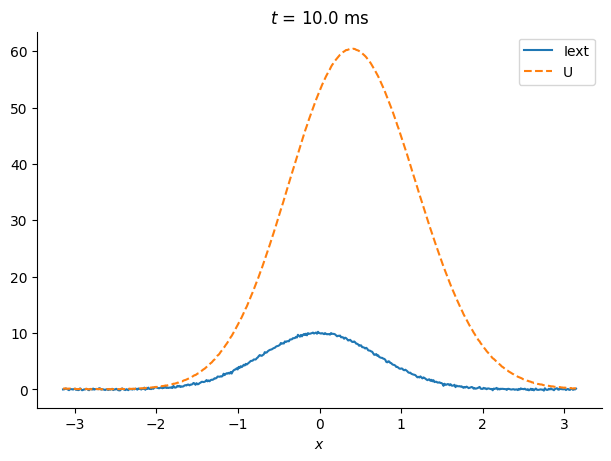

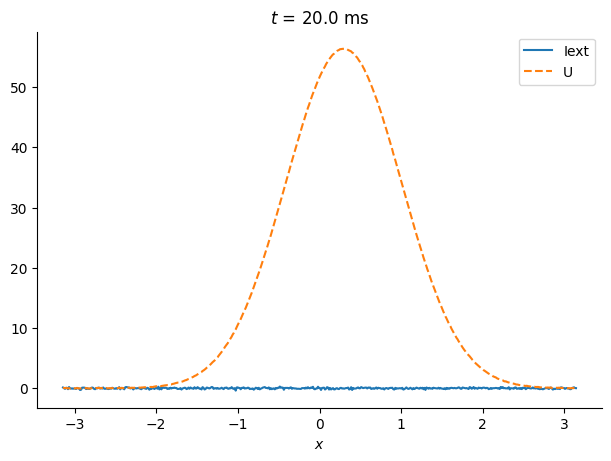

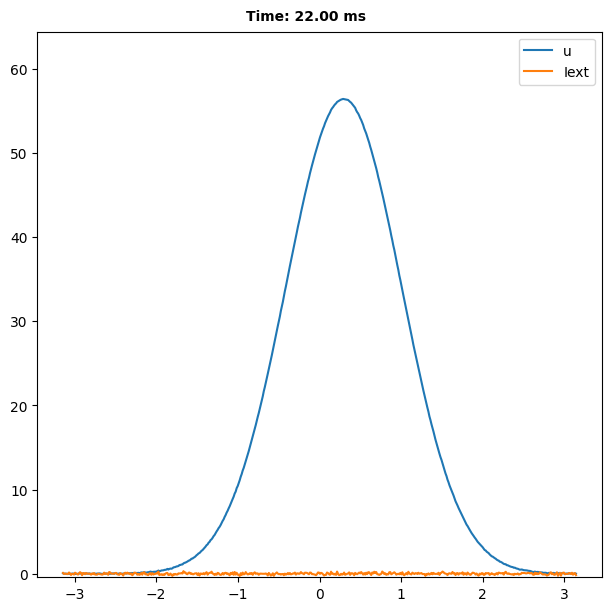

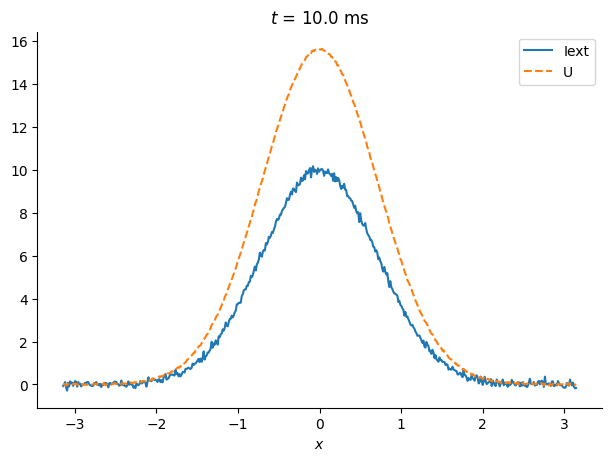

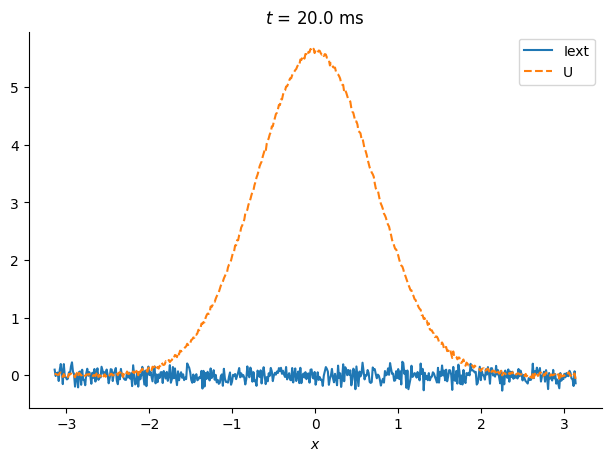

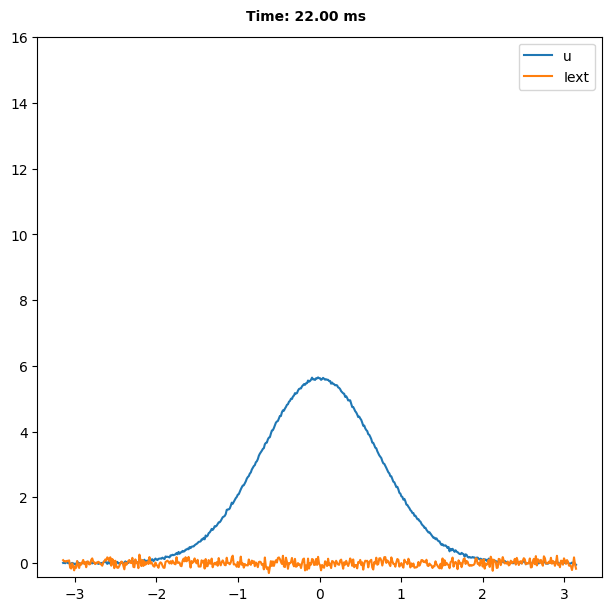

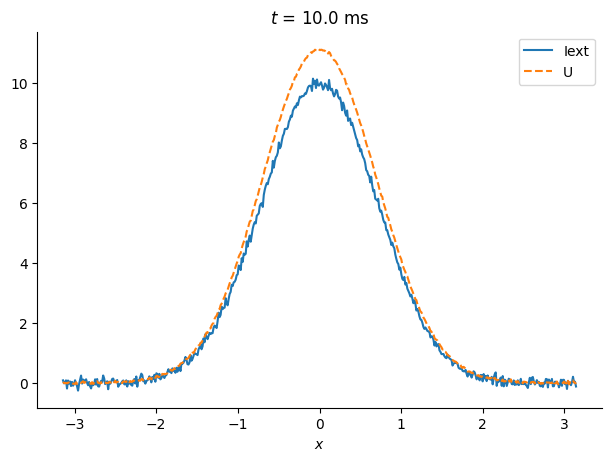

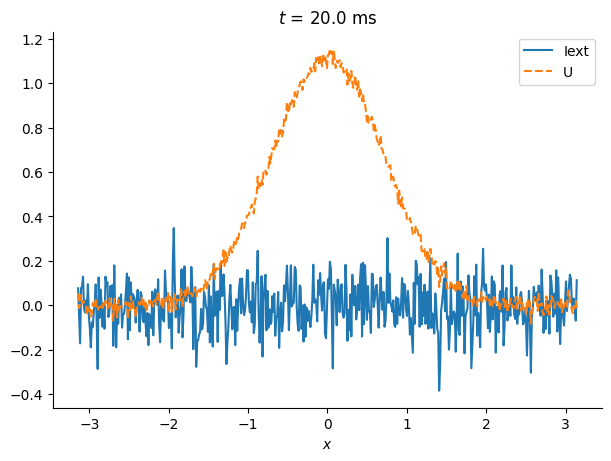

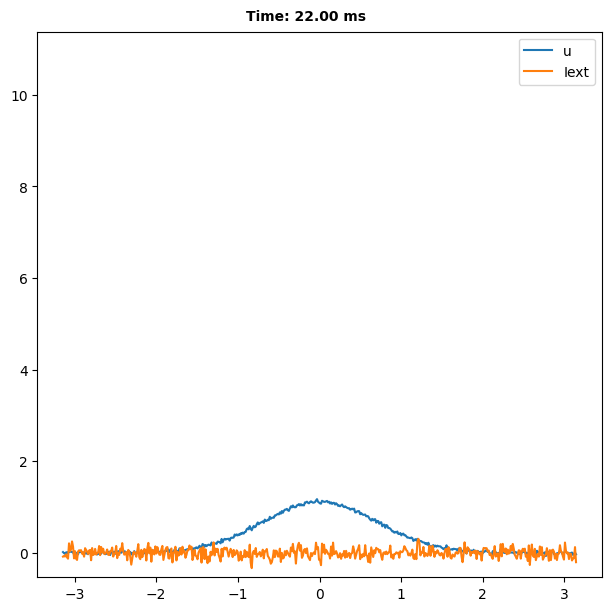

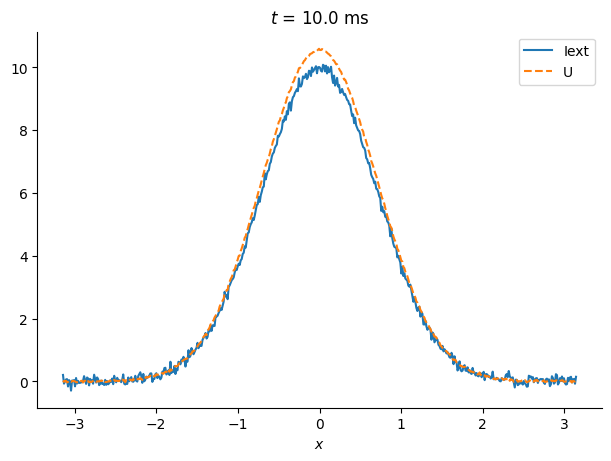

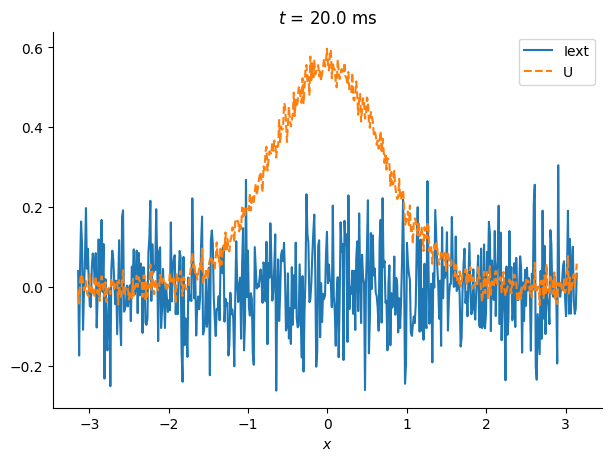

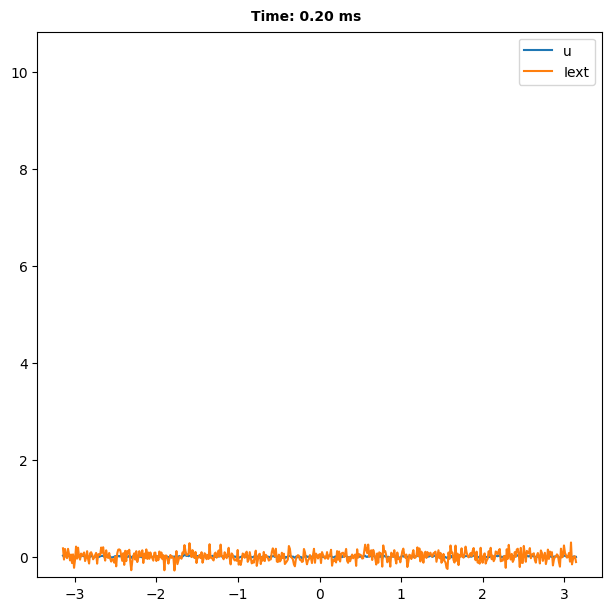

In [ ]:
def Persistent_Activity(k=0.1,J0=1.):
    # 初始化一个CANN
    cann = CANN1D(num=512, k=k, J0=J0)

    # 生成外部刺激，从第2到12ms，持续10ms
    dur1, dur2, dur3 = 2., 10., 10.
    I1 = cann.get_stimulus_by_pos(0.)
    Iext, duration = bp.inputs.section_input(values=[0., I1, 0.],
                                             durations=[dur1, dur2, dur3],
                                             return_length=True)
    noise_level = 0.1
    noise = bm.random.normal(0., noise_level, (int(duration / bm.get_dt()), len(I1)))
    Iext += noise

    # TODO：运行数值模拟，监控变量u的历史变化？？
    runner = bp.DSRunner(cann, inputs=[('input', Iext, 'iter')], monitors=['u'])
    runner.run(duration)

    # 可视化
    def plot_response(t):
        fig, gs = bp.visualize.get_figure(1, 1, 4.5, 6)
        ax = fig.add_subplot(gs[0, 0])
        ts = int(t / bm.get_dt())
        I, u = Iext[ts], runner.mon.u[ts]
        ax.plot(cann.x, I, label='Iext')
        ax.plot(cann.x, u, linestyle='dashed', label='U')
        ax.set_title(r'$t$' + ' = {} ms'.format(t))
        ax.set_xlabel(r'$x$')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend()
        # plt.savefig(f'CANN_t={t}.pdf', transparent=True, dpi=500)

    plot_response(t=10.)
    plot_response(t=20.)

    # def mp4_save(k):
    #     bp.visualize.animate_1D(
    #         dynamical_vars=[{'ys': runner.mon.u, 'xs': cann.x, 'legend': 'u'},
    #                         {'ys': Iext, 'xs': cann.x, 'legend': 'Iext'}],
    #         frame_step=1,
    #         frame_delay=40,
    #         show=False,
    #         save_path=f'CANN_k={k}.mp4',
    #     )

    bp.visualize.animate_1D(
        dynamical_vars=[{'ys': runner.mon.u, 'xs': cann.x, 'legend': 'u'},
                        {'ys': Iext, 'xs': cann.x, 'legend': 'Iext'}],
        frame_step=1,
        frame_delay=40,
        show=True,
        save_path=f'CANN_k={k}.gif',
    )
    # plt.show()


# Persistent_Activity(k=0.1)


# TODO: 修改k的参数
Persistent_Activity(k=0.01)
Persistent_Activity(k=0.1)
Persistent_Activity(k=0.5)
Persistent_Activity(k=1)

# 2 Adaptive Continuous Attractor Neural Network


Here we will implement the following paper:

- Mi, Y., Fung, C. C., Wong, M. K. Y., & Wu, S. (2014). Spike frequency adaptation implements anticipative tracking in continuous attractor neural networks. Advances in neural information processing systems, 1(January), 505.


The dynamics of CANN with SFA

1. Synaptic current dynamics (a negative feedback current $V$ is added to the model): 

$$ 
\tau \frac{dU(x,t)}{dt} = -U(x,t)+\int_x' J(x,x')r(x',t)dx' + I^{ext} - V(x,t)
$$

2. Spike frequency adaptation (dynamics of V): 
$$ 
\tau_v \frac{dV(x,t)}{dt} = -V(x,t)+ mU(x,t)
$$
## 2.1 Customize a CANN with SFA

与实现上文中的CANN模型一样，我们将带有SFA的连续吸引子网络定义为一个``brainpy.dyn.NeuDyn``子类。其实现的具体流程为：

1、初始化模型的参数；

2、初始化特征空间相关参数；

3、初始化变量

4、定义积分函数

5、距离函数：将距离转换到``[-z_range/2, z_range/2)``之间

6、波包输入函数：获取各个神经元到pos处神经元的输入

7、网络更新函数

**任务1**：我们需要完成如下两个公式的编程，即将微分方程写成Python微分函数：

$$ 
\tau\frac{dU(x,t)}{dt} = -U(x,t) + I^{rec} (x,t) + I^{ext}(x,t) \\
$$
将上述公式定义为``self.du``函数。


$$
\tau_v \frac{dV(x,t)}{dt} = -V(x,t)+ mU(x,t)
$$
将上述公式定义为``self.v``函数。


In [5]:
class CANN1D_SFA(bp.dyn.NeuDyn):
  def __init__(self, num, m = 0.1, tau=1., tau_v=10., k=8.1, a=0.5, A=10., J0=4.,
               z_min=-bm.pi, z_max=bm.pi, **kwargs):
    super(CANN1D_SFA, self).__init__(size=num, **kwargs)

    # 1、初始化参数
    self.tau = tau
    self.tau_v = tau_v #time constant of SFA
    self.k = k
    self.a = a
    self.A = A
    self.J0 = J0
    self.m = m #SFA strength
      
    # 2、初始化特征空间相关参数
    self.z_min = z_min
    self.z_max = z_max
    self.z_range = z_max - z_min
    self.x = bm.linspace(z_min, z_max, num)
    self.rho = num / self.z_range
    self.dx = self.z_range / num

    # 3、初始化变量
    self.u = bm.Variable(bm.zeros(num))
    self.v = bm.Variable(bm.zeros(num)) #SFA current
    self.input = bm.Variable(bm.zeros(num))
    self.conn_mat = self.make_conn(self.x)  # 连接矩阵

    # 4、定义积分函数
    self.integral = bp.odeint(bp.JointEq(self.du, self.dv))

  # 微分方程
  def du(self, u, t, v, Irec, Iext):
    # TODO: 定义u的微分方程
    du = (-u + Irec + Iext - v) / self.tau
    return du
    # return (?????) / self.tau

  def dv(self, v, t, u):
    # TODO: 定义v的微分方程
    dv = (-v + self.m * u) / self.tau_v
    return dv
    # return (????) / self.tau_v

  # 5、将距离转换到[-z_range/2, z_range/2)之间
  def dist(self, d):
    d = bm.remainder(d, self.z_range)
    d = bm.where(d > 0.5 * self.z_range, d - self.z_range, d)
    return d

  # 计算连接矩阵
  def make_conn(self, x):
    assert bm.ndim(x) == 1
    d = self.dist(x - x[:, None])  # 距离矩阵
    Jxx = self.J0 * bm.exp(-0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a) 
    return Jxx

  # 6、获取各个神经元到pos处神经元的输入
  def get_stimulus_by_pos(self, pos):
    return self.A * bm.exp(-0.25 * bm.square(self.dist(self.x - pos) / self.a))

  # 7、网络更新函数
  def update(self, x=None):
    u2 = bm.square(self.u)
    r = u2 / (1.0 + self.k * bm.sum(u2))
    Irec = bm.dot(self.conn_mat, r)
    u, v = self.integral(self.u, self.v, bp.share['t'],Irec, self.input)
    self.u[:] = bm.where(u>0,u,0)
    self.v[:] = v
    self.input[:] = 0.  # 重置外部电流

## 2.2 Simulate the anticipative tracking

我们将一个移动的波包输入投影到CAN-SFA 中，我们期望网络会产生一个能够跟踪刺激的波包。

**任务1**：移动输入已经写好了，我们的主要任务是定义一个``brainpy.DSRunner``用于运行此模型。其中，DSRunner需要监控变量u的历史变化轨迹。

**任务2**：我们的另一个任务是通过修改外界输入``v_ext``的速度大小，来观察网络是否还能跟踪此输入。

  0%|          | 0/10100 [00:00<?, ?it/s]

Saving the animation into CANN_SFA_m=10_v_ext=0.006.gif ...
MovieWriter imagemagick unavailable; using Pillow instead.


  0%|          | 0/10100 [00:00<?, ?it/s]

Saving the animation into CANN_SFA_m=10_v_ext=0.06.gif ...
MovieWriter imagemagick unavailable; using Pillow instead.


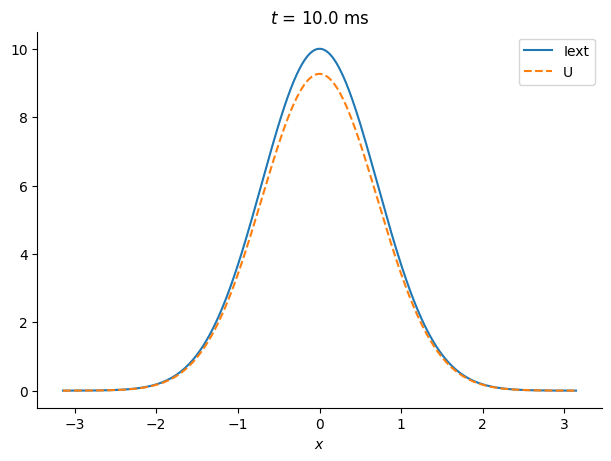

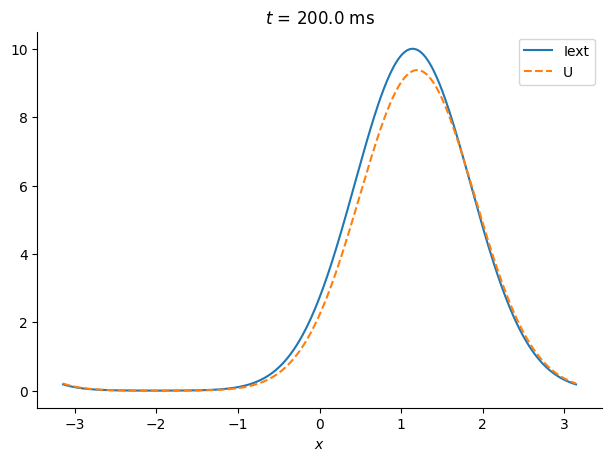

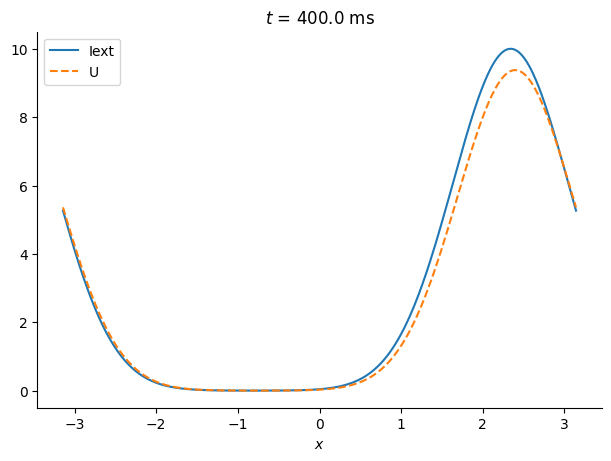

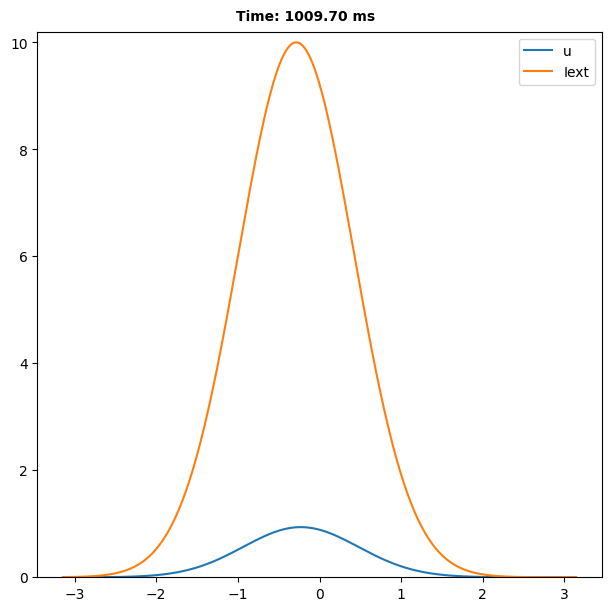

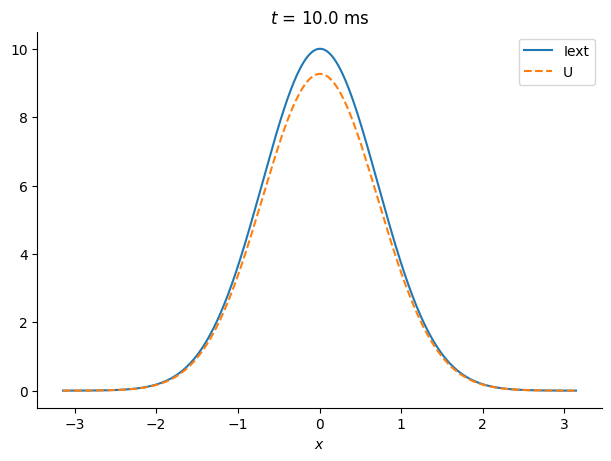

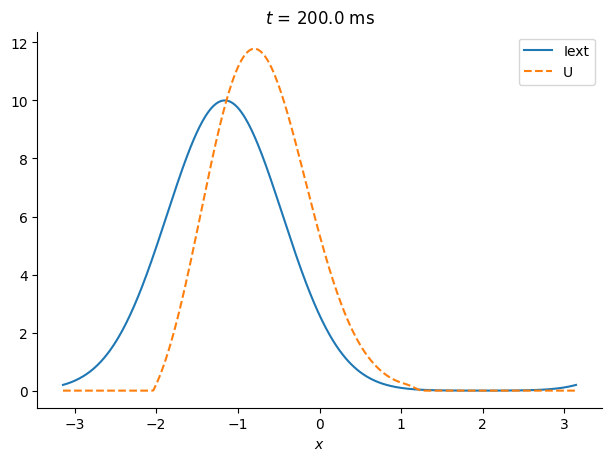

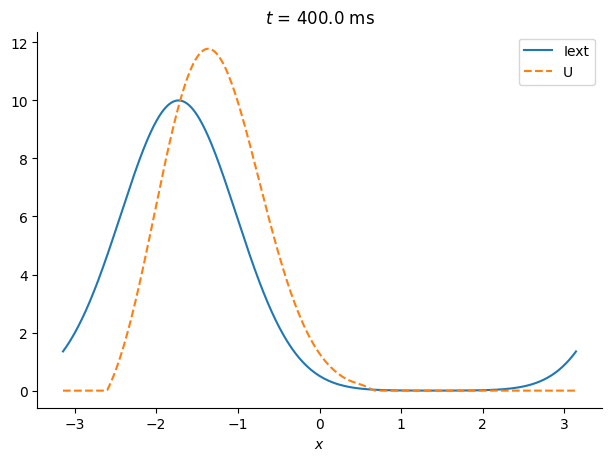

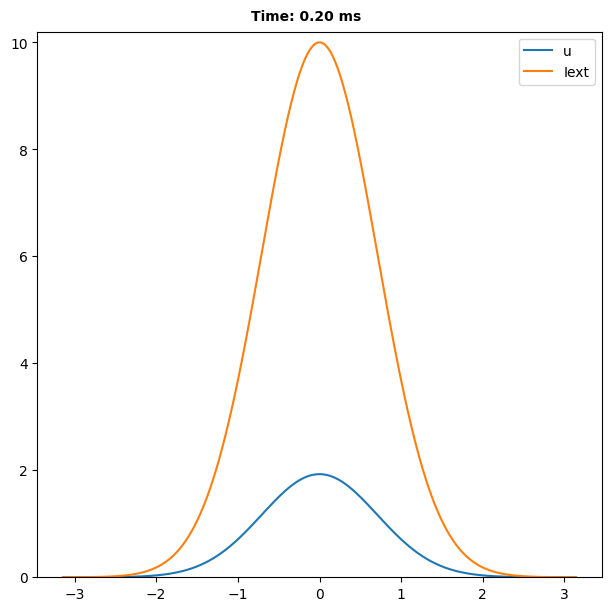

In [6]:
import numpy as np
def anticipative_tracking(m=10,v_ext=6*1e-3):
    cann_sfa = CANN1D_SFA(num=512, m=m)
    
    # 定义随时间变化的外部刺激
    v_ext = v_ext
    dur1, dur2, = 10., 1000.
    num1 = int(dur1 / bm.get_dt())
    num2 = int(dur2 / bm.get_dt())
    position = np.zeros(num1 + num2)
    for i in range(num2):
        pos = position[i+num1-1]+v_ext*bm.dt
        # the periodical boundary
        pos = np.where(pos>np.pi, pos-2*np.pi, pos)
        pos = np.where(pos<-np.pi, pos+2*np.pi, pos)
        # update
        position[i+num1] = pos
    position = position.reshape((-1, 1))
    Iext = cann_sfa.get_stimulus_by_pos(position)

    # TODO：任务1 - 创建DSRunner，运行模拟
    runner = bp.DSRunner(cann_sfa, inputs=['input', Iext, 'iter'], monitors=['u', 'v'])
    runner.run(dur1 + dur2)

    # 可视化
    def plot_response(t, extra_fun=None):
        fig, gs = bp.visualize.get_figure(1, 1, 4.5, 6)
        ax = fig.add_subplot(gs[0, 0])
        ts = int(t / bm.get_dt())
        I, u = Iext[ts], runner.mon.u[ts]
        ax.plot(cann_sfa.x, I, label='Iext')
        ax.plot(cann_sfa.x, 10*u, linestyle='dashed', label='U')
        ax.set_title(r'$t$' + ' = {} ms'.format(t))
        ax.set_xlabel(r'$x$')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend()

    plot_response(t=10.)
    plot_response(t=200.)
    plot_response(t=400.)
    bp.visualize.animate_1D(
        dynamical_vars=[{'ys': runner.mon.u, 'xs': cann_sfa.x, 'legend': 'u'},
                        {'ys': Iext, 'xs': cann_sfa.x, 'legend': 'Iext'}],
        frame_step=5,
        frame_delay=50,
        show=True,
        save_path=f'CANN_SFA_m={m}_v_ext={v_ext}.gif',
    )
    # plt.show()


anticipative_tracking()

# TODO: 任务2，改变输入移动的快慢
anticipative_tracking(v_ext=6*1e-2)

# 3 Discussion Homework


You are encouraged to draw upon the principles and mechanisms you've learned about Continuous-Attractor Neural Networks (CANNs) and to propose hypotheses, experimental designs, or model modifications to explore any of the following topics, but not limited to, in greater depth: 

**Background**:

Continuous Attractor Neural Networks (CANNs) are a type of recurrent neural network that can store and retrieve information in a continuous attractor state. This state is a stable pattern of neural activity that can be maintained even without external input. CANNs are thought to underlie a variety of cognitive functions, including memory, decision-making, and attention.

**Objectives**:

- Understand the concept of continuous attractor states in neural networks.

- Explore the applications of CANNs in modeling cognitive functions.

- Investigate the challenges and potential of CANNs in artificial intelligence.

**Discussion Topics**:

1. Working Memory Modeling with CANNs:

Discuss how CANNs can be used to model working memory, the temporary storage system that allows us to keep track of information while using it. Explore how different patterns of neural activity can represent different pieces of information in attractor states.

2. Decision-Making and CANNs:

Examine how CANNs can be employed to model decision-making processes, where options are weighed and the best one is selected. Consider representing each option as a different attractor state and how the network transitions to the optimal state.

3. Attention Mechanisms and CANNs:

Investigate how CANNs can model attention, the ability to focus on specific information while ignoring irrelevant details. Discuss how attractor states can represent attended information and how connection strengths can prioritize relevant information.

4. CANNs in Other Cognitive Functions:

Explore the potential of CANNs in modeling other cognitive functions, such as language processing and motor control. Discuss how CANNs can represent and manipulate linguistic or motor information in attractor states.

5. CANNs in Artificial Intelligence:

Discuss the potential applications of CANNs in developing new artificial intelligence systems. Consider how CANNs can contribute to AI systems that mimic cognitive functions like memory, decision-making, and attention.

6. Challenges and Future Directions of CANNs:

Identify the challenges and limitations of developing and applying CANNs in real-world applications. Discuss potential solutions and future research directions to overcome these challenges.

**Conclusion**:

CANNs offer a promising approach to modeling cognitive functions and developing advanced artificial intelligence systems. By exploring the principles and applications of CANNs, we can gain a deeper understanding of the brain's computational mechanisms and pave the way for innovative AI technologies.
